In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [18]:
def generate_data(n, separation_boundary, x0min=0, x0max=1, x1min=0, x1max=1):
    x0distr = stats.uniform(loc=x0min, scale=x0max-x0min)
    x1distr = stats.uniform(loc=x1min, scale=x1max-x1min)
    x0s = x0distr.rvs(size=n)
    x1s = x1distr.rvs(size=n)
    X = np.array(list(zip(x0s, x1s)))
    y = np.sign([separation_boundary(xi) for xi in X])
    y = np.where(y == 0, 1, y)
    return X, y

def plot_data(X, y):
    posX = X[np.where(y == 1)]
    negX = X[np.where(y == -1)]
    plt.plot(posX[:,0], posX[:,1], 'r.')
    plt.plot(negX[:,0], negX[:,1], 'b.')


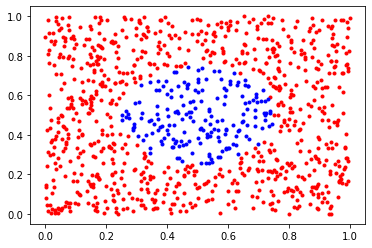

In [23]:
# x1 = x0 * 0.5 + 0.25
f0 = lambda x: np.dot(x, [0.5, -1]) + 0.25 #= 0
# circle
f1 = lambda x: np.linalg.norm(x-[0.5, 0.5]) - 0.25 #= 0


X, y = generate_data(1000, f1)
plot_data(X, y)